# Where should you live in London?
> Imagine you are moving to London, UK. you would like to live in a neighborhood that is safe and popular. We'll use the London crime data and the Foursquare API to select which neighborhood best fits our needs.  

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [segmentation, k-means clustering, web scraping]
- hide: false

Imagine you are moving to London, UK. It's a major metropolitan city, a financial hub, a famous tourist destination, and home to around 9 million people. But as with every big city, crime is a concern, and you would like to live in a neighborhood that is safe and also popular. In this blog, we'll use the London Crime data and the Foursquare API to select which neighborhood best fits our needs.  
 
*Note: To view the interactive maps, open the notebook in Google Colab.* 
The London Crime data consists of more than 13 million rows containing counts of criminal reports by month, LSOA (Lower Super Output Area) borough, and major/minor category. You can [download the data here](https://www.kaggle.com/jboysen/london-crime#london_crime_by_lsoa.csv).  
About the data:  
- `lsoa_code`: code for Lower Super Output Area in Greater London.
- `borough`: Common name for London borough.
- `major_category`: High level categorization of crime
- `minor_category`: Low level categorization of crime within major category.
- `value`: monthly reported count of categorical crime in given borough
- `year`: Year of reported counts, 2008-2016
- `month`: Month of reported counts, 1-12

In [318]:
# import libraries
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import requests # library to handle requests
from bs4 import BeautifulSoup # library for web scraping

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# transforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


Define Foursquare credentials.

In [319]:
CLIENT_ID = 'XXXX'
CLIENT_SECRET = 'XXXX'
VERSION = '20191912'

# limit the number of venues returned by the foursquare API
LIMIT = 50

Read the dataset into a pandas dataframe.

In [320]:
df = pd.read_csv('london_crime_by_lsoa.csv')
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


In [321]:
# dimensions of the dataframe
df.shape

(13490604, 7)

---
### Preprocessing the data

In [322]:
# remove all null value entries
df = df[df.value != 0]

# reset the index and drop the previous index
df = df.reset_index(drop=True)

df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000086,Barking and Dagenham,Theft and Handling,Other Theft Person,1,2009,5
2,E01001301,Ealing,Theft and Handling,Other Theft Person,2,2012,1
3,E01001794,Hackney,Violence Against the Person,Harassment,1,2013,2
4,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4


In [323]:
# new dimensions of the dataframe
df.shape

(3419099, 7)

Change the column names.

In [324]:
df.columns = ['LSOA_Code', 'Borough', 'Major_Category', 'Minor_Category', 'No_of_Crimes', 'Year', 'Month']
df.head(2)

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000086,Barking and Dagenham,Theft and Handling,Other Theft Person,1,2009,5


In [325]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3419099 entries, 0 to 3419098
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   LSOA_Code       object
 1   Borough         object
 2   Major_Category  object
 3   Minor_Category  object
 4   No_of_Crimes    int64 
 5   Year            int64 
 6   Month           int64 
dtypes: int64(3), object(4)
memory usage: 182.6+ MB


**What is the total number of crimes in each Borough?**

In [326]:
df['Borough'].value_counts()

Lambeth                   152784
Croydon                   147203
Southwark                 144362
Ealing                    140006
Newham                    137275
Brent                     129925
Lewisham                  128232
Barnet                    127194
Tower Hamlets             120099
Wandsworth                118995
Enfield                   117953
Hackney                   116521
Haringey                  116315
Waltham Forest            114603
Camden                    112029
Islington                 111755
Hillingdon                110614
Westminster               110070
Bromley                   109855
Hounslow                  106561
Redbridge                 105932
Greenwich                 104654
Hammersmith and Fulham     92084
Barking and Dagenham       86849
Havering                   82288
Kensington and Chelsea     81295
Harrow                     73993
Bexley                     73948
Merton                     73661
Sutton                     62776
Richmond u

The Boroughs of Lambeth, Croydon, Southwark and Ealing have the highest number of crimes from the year 2008 to 2016.

**What is the total number of crimes per major category?**

In [327]:
df['Major_Category'].value_counts()

Theft and Handling             1136994
Violence Against the Person     894859
Criminal Damage                 466268
Burglary                        441209
Drugs                           231894
Robbery                         163549
Other Notifiable Offences        80569
Fraud or Forgery                  2682
Sexual Offences                   1075
Name: Major_Category, dtype: int64

Pivot the table to view the number of crimes for each major category in each Borough.

In [328]:
London_crime = pd.pivot_table(df, values=['No_of_Crimes'], 
                              index=['Borough'],
                             columns=['Major_Category'],
                             aggfunc=np.sum, fill_value=0)
London_crime.head()

No_of_Crimes                                          \
Major_Category           Burglary Criminal Damage  Drugs Fraud or Forgery   
Borough                                                                     
Barking and Dagenham        18103           18888   9188              205   
Barnet                      36981           21024   9796              175   
Bexley                      14973           17244   7346              106   
Brent                       28923           20569  25978              157   
Bromley                     27135           24039   8942              196   

                                                                        \
Major_Category       Other Notifiable Offences Robbery Sexual Offences   
Borough                                                                  
Barking and Dagenham                      2819    6105              49   
Barnet                                    2953    7374              38   
Bexley                                    1999    2338              22   
Brent                                     3711   12473              39   
Bromley                                   2637    4868              31   

                                                                     
Major_Category       Theft and Handling Violence Against the Person  
Borough                                                              
Barking and Dagenham              50999                       43091  
Barnet                            87285                       46565  
Bexley                            40071                       30037  
Brent                             72523                       63178  
Bromley                           69742                       46759

In [329]:
# reset the index
London_crime.reset_index(inplace=True)

In [330]:
# total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head()

Borough No_of_Crimes                         \
Major_Category                           Burglary Criminal Damage  Drugs   
0               Barking and Dagenham        18103           18888   9188   
1                             Barnet        36981           21024   9796   
2                             Bexley        14973           17244   7346   
3                              Brent        28923           20569  25978   
4                            Bromley        27135           24039   8942   

                                                                   \
Major_Category Fraud or Forgery Other Notifiable Offences Robbery   
0                           205                      2819    6105   
1                           175                      2953    7374   
2                           106                      1999    2338   
3                           157                      3711   12473   
4                           196                      2637    4868   

                                                                               \
Major_Category Sexual Offences Theft and Handling Violence Against the Person   
0                           49              50999                       43091   
1                           38              87285                       46565   
2                           22              40071                       30037   
3                           39              72523                       63178   
4                           31              69742                       46759   

                 Total  
Major_Category          
0               149447  
1               212191  
2               114136  
3               227551  
4               184349

Remove the multi-index so that it will be easier to merge the columns.

In [331]:
London_crime.columns = London_crime.columns.map(' '.join)
London_crime.head()

,Borough,No_of_Crimes Burglary,No_of_Crimes Criminal Damage,No_of_Crimes Drugs,No_of_Crimes Fraud or Forgery,No_of_Crimes Other Notifiable Offences,No_of_Crimes Robbery,No_of_Crimes Sexual Offences,No_of_Crimes Theft and Handling,No_of_Crimes Violence Against the Person,Total
0,Barking and Dagenham,18103,18888,9188,205,2819,6105,49,50999,43091,149447
1,Barnet,36981,21024,9796,175,2953,7374,38,87285,46565,212191
2,Bexley,14973,17244,7346,106,1999,2338,22,40071,30037,114136
3,Brent,28923,20569,25978,157,3711,12473,39,72523,63178,227551
4,Bromley,27135,24039,8942,196,2637,4868,31,69742,46759,184349


Let's rename the columns for better comprehensibility.

In [332]:
London_crime.columns = ['Borough', 'Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery', 'Other Notifiable Offenses', 
                        'Robbery', 'Sexual Offences', 'Theft and Handling', 'Violence Against the Person', 'Total']
London_crime

,Borough,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offenses,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,18103,18888,9188,205,2819,6105,49,50999,43091,149447
1,Barnet,36981,21024,9796,175,2953,7374,38,87285,46565,212191
2,Bexley,14973,17244,7346,106,1999,2338,22,40071,30037,114136
3,Brent,28923,20569,25978,157,3711,12473,39,72523,63178,227551
4,Bromley,27135,24039,8942,196,2637,4868,31,69742,46759,184349
5,Camden,27939,18482,21816,123,3857,9286,36,140596,53012,275147
6,City of London,15,16,33,0,17,24,0,561,114,780
7,Croydon,33376,31218,19162,270,4340,12645,55,91437,67791,260294
8,Ealing,30831,25613,18591,175,4406,9568,52,93834,68492,251562
9,Enfield,30213,22487,13251,132,3293,9059,38,70371,45036,193880


---
### Scraping data from the web
Let's scrape additional information about the different Boroughs in London from the ["List of London boroughs" Wikipedia page](https://en.wikipedia.org/wiki/List_of_London_boroughs).  
We'll use the **Beautiful Soup** library to scrape the latitude and longitude coordinates of the boroghs in London.

In [333]:
#collapse-output
# getting data from internet
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page = requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())

<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"XnGIbgpAMNIAAU@V7W8AAACD","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":943613985,"wgRevisionId":943613985,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories

Extract the raw table inside the webpage.

In [334]:
#collapse-output
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a class="new" href="/w/index.php?title=Barking_Town_Hall&amp;actio

Convert the table into a dataframe.

In [335]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


There is a second table on the webpage that contains the additional Borough - City of London.

In [336]:
# read the second table
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# rename the columns to match the previous table 
London_table1.columns = ['Borough', 'Inner', 'Status', 'Local authority', 'Political control', 'Headquarters', 
                         'Area (sq mi)', 'Population (2013 est)[1]', 'Co-ordinates', 'Nr. in map']

# view the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


Let's append the dataframes of 'London_table' and 'London_table1' together. A continuous index value will be maintained across the rows in the new appended dataframe.

In [337]:
London_table = London_table.append(London_table1, ignore_index=True)

# check the last rows of the data set
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


We'll remove the unnecessary strings in the dataset.

In [338]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [339]:
# type of the dataframe
type(London_table)

pandas.core.frame.DataFrame

In [340]:
# shape of the dataframe
London_table.shape

(33, 10)

Check if the Borough in both the dataframes match.

In [341]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

These 3 Boroughs don't match because of the unnecessary symbols like '[ ]' present.  
Let's find the index of the 3 Boroughs that do not match.

In [342]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


Change the Borough names to match the other data frame.

In [343]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

In [344]:
set(df.Borough) - set(London_table.Borough)

set()

The Borough names in both dataframes match.  
Now, we combine both the dataframes together.

In [345]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offenses,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,18103,18888,9188,205,2819,6105,49,50999,43091,149447,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,36981,21024,9796,175,2953,7374,38,87285,46565,212191,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,14973,17244,7346,106,1999,2338,22,40071,30037,114136,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,28923,20569,25978,157,3711,12473,39,72523,63178,227551,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,27135,24039,8942,196,2637,4868,31,69742,46759,184349,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [346]:
# shape of the dataframe
Ld_crime.shape

(33, 20)

In [347]:
# check if the names of Boroughs in both the dataframes match
set(df.Borough) - set(Ld_crime.Borough)

set()

Rearrange the Columns.

In [348]:
# list the column names of the dataframe
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Fraud or Forgery',
 'Other Notifiable Offenses',
 'Robbery',
 'Sexual Offences',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [349]:
# rename the Population column
Ld_crime = Ld_crime.rename(columns = {'Population (2013 est)[1]':'Population'})

In [350]:
columnsTitles = ['Borough', 'Local authority', 'Political control', 'Headquarters', 'Area (sq mi)', 'Population', 'Co-ordinates',
               'Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery', 'Other Notifiable Offenses', 'Robbery', 'Sexual Offenses', 
                'Theft and Handling', 'Violence Against the Person', 'Total']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough', 'Local authority', 'Political control', 'Headquarters', 'Area (sq mi)', 'Population', 'Co-ordinates',
               'Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery', 'Other Notifiable Offenses', 'Robbery', 'Sexual Offenses', 
                'Theft and Handling', 'Violence Against the Person', 'Total']]

Ld_crime

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population,Co-ordinates,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offenses,Robbery,Sexual Offenses,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,18103,18888,9188,205,2819,6105,NaN,50999,43091,149447
1,Barnet,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,36981,21024,9796,175,2953,7374,NaN,87285,46565,212191
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,14973,17244,7346,106,1999,2338,NaN,40071,30037,114136
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,28923,20569,25978,157,3711,12473,NaN,72523,63178,227551
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,27135,24039,8942,196,2637,4868,NaN,69742,46759,184349
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,27939,18482,21816,123,3857,9286,NaN,140596,53012,275147
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,15,16,33,0,17,24,NaN,561,114,780
7,Croydon,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,33376,31218,19162,270,4340,12645,NaN,91437,67791,260294
8,Ealing,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,30831,25613,18591,175,4406,9568,NaN,93834,68492,251562
9,Enfield,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30213,22487,13251,132,3293,9059,NaN,70371,45036,193880


In [351]:
# shape of the dataframe
Ld_crime.shape

(33, 17)

---
### Exploratory Data Analysis

In [352]:
# descriptive statistics of the data
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offenses,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,22857.363636,19119.333333,14265.606061,161.363636,3222.696970,7844.636364,38.575758,80662.454545,47214.575758,195386.606061
std,7452.366846,5942.903618,7544.259564,81.603775,1362.107294,4677.643075,15.139002,45155.624776,17226.165191,79148.057551
min,15.000000,16.000000,33.000000,0.000000,17.000000,24.000000,0.000000,561.000000,114.000000,780.000000
25%,18103.000000,17244.000000,8942.000000,106.000000,2358.000000,4744.000000,27.000000,52609.000000,33968.000000,149447.000000
50%,24871.000000,20405.000000,14101.000000,157.000000,3293.000000,7688.000000,40.000000,77940.000000,50943.000000,203879.000000
75%,27980.000000,22755.000000,18389.000000,207.000000,3963.000000,10084.000000,47.000000,92523.000000,59993.000000,228613.000000
max,36981.000000,31218.000000,34031.000000,323.000000,6504.000000,18408.000000,71.000000,277617.000000,72726.000000,455028.000000


In [353]:
# import libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot')

Check if the column names are strings.

In [354]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# check the column labels type 
all(isinstance(column, str) for column in Ld_crime.columns)

True

Let's sort the total crimes in descending order to see 5 boroughs with the highest number of crimes.

In [355]:
Ld_crime.sort_values(['Total'], ascending=False, axis=0, inplace=True)

df_top5 = Ld_crime.head()
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population,Co-ordinates,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offenses,Robbery,Sexual Offenses,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,29295,20405,34031,273,6148,15752,NaN,277617,71448,455028
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,30199,26136,25083,137,4520,18408,NaN,114899,72726,292178
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,27980,24450,27381,321,4696,16153,NaN,109432,68356,278809
5,Camden,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,27939,18482,21816,123,3857,9286,NaN,140596,53012,275147
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,25356,24177,18389,323,4456,16913,NaN,106146,66221,262024


Let's visualize these 5 boroughs.

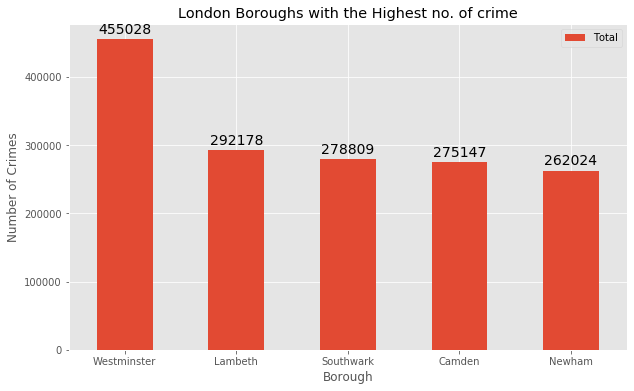

In [356]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('London Boroughs with the Highest no. of crime')

# create a function to display the percentage.
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Okay. Now we know which places you need to stay away from.  

Now, let's sort the total crimes in ascending order to see 5 boroughs with the lowest number of crimes.

In [357]:
Ld_crime.sort_values(['Total'], ascending=True, axis=0, inplace=True)

df_bot5 = Ld_crime.head()
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population,Co-ordinates,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offenses,Robbery,Sexual Offenses,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,15,16,33,0,17,24,NaN,561,114,780
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,10131,10610,5682,65,1332,1702,NaN,38226,21540,89306
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,16097,11722,4707,37,1420,1590,NaN,40858,20314,96771
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,13207,14474,4586,57,1393,2308,NaN,39533,25409,100987
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,14973,17244,7346,106,1999,2338,NaN,40071,30037,114136


Let's visualize these 5 boroughs.

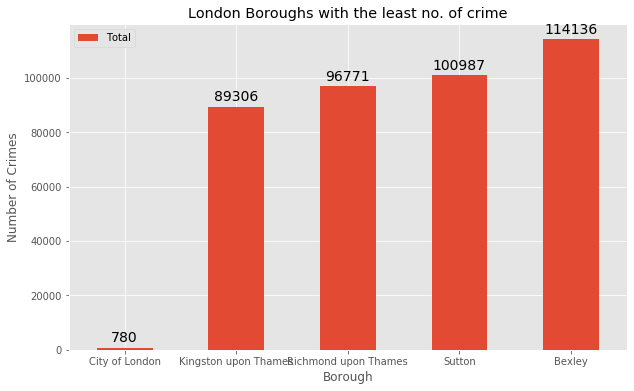

In [358]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') 
ax.set_xlabel('Borough') 
ax.set_title('London Boroughs with the least no. of crime')

# create a function to display the percentage.
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

The borough **City of London** has the lowest crime recorded over the years. Let's look into its details.

In [359]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population']]
df_col

,Borough,Total,Area (sq mi),Population
6,City of London,780,1.12,7000


According to the London Boroughs [Wikipedia page](https://en.wikipedia.org/wiki/List_of_London_boroughs), the City of London is the 33rd principal division of Greater London, but it is not a London borough. You also realise that living in this area would be very expensive and you're not looking to spend most of your income on rent.  
So let's focus on the next safest borough i.e. **Kingston upon Thames**, just to keep our options open.

Visualize different types of crimes in the borough 'Kingston upon Thames'.

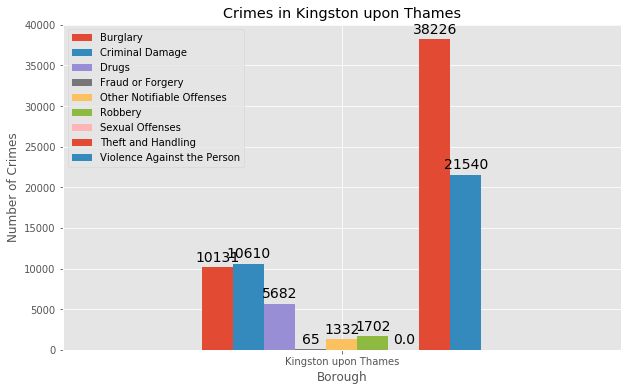

In [360]:
df_bc1 = df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough', 'Burglary', 'Criminal Damage', 'Drugs', 'Fraud or Forgery', 'Other Notifiable Offenses', 
                'Robbery', 'Sexual Offenses', 'Theft and Handling', 'Violence Against the Person']]

df_bc.set_index('Borough', inplace=True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') 
ax.set_xlabel('Borough') 
ax.set_title('Crimes in Kingston upon Thames')

# create a function to display the percentage.
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

This borough is a great option for you to live in and is also extremely safe compared to the other boroughs.

---
### Dataset of the Neighborhood
The list of Neighborhoods in the Royal Borough of Kingston upon Thames can be [found here](https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames).

In [313]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Kingston upon Thames','Kingston Vale',
                'Malden Rushett','Motspur Park','New Malden','Norbiton','Old Malden','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','']

df_neigh = {'Neighborhood':Neighborhood, 'Borough':Borough, 'Latitude':Latitude,  'Longitude':Longitude}
kut_neigh = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neigh

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Kingston upon Thames,Kingston upon Thames,,
5,Kingston Vale,Kingston upon Thames,,
6,Malden Rushett,Kingston upon Thames,,
7,Motspur Park,Kingston upon Thames,,
8,New Malden,Kingston upon Thames,,
9,Norbiton,Kingston upon Thames,,


Find the co-ordinates of each neighborhood in the Kingston upon Thames borough.

In [315]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{}, London, United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent='London_agent')
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)

print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3033105, -0.2828604]


In [362]:
df_neigh = {'Neighborhood':Neighborhood, 'Borough':Borough, 'Latitude':Latitude,  'Longitude':Longitude}
kut_neigh = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neigh

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
5,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
6,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
7,Motspur Park,Kingston upon Thames,51.390985,-0.248898
8,New Malden,Kingston upon Thames,51.405335,-0.263407
9,Norbiton,Kingston upon Thames,51.409999,-0.287396


Let's get the co-ordinates of Berrylands, which is the center neighborhood of the Kingston upon Thames borough.

In [363]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent='ld_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical co-ordinates of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geographical co-ordinates of Berrylands, London are 51.3937811, -0.2848024.


Let's visualize the neighborhood of Kingston upon Thames borough.

In [366]:
# create map of London using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neigh['Latitude'], kut_neigh['Longitude'], 
                                           kut_neigh['Borough'], kut_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup=label, color='blue', fill=True, 
                        fill_color='#3186cc', fill_opacity=0.7, parse_html=False).add_to(map_lon)
    
map_lon

---
### Modeling
- Find all the venues within a 500 meter radius of each neighborhood.
- Perform one hot encoding on the venues data.
- Group the venues by the neighborhood and calculate their mean.
- Perform a k-means clustering.

#### Create a function to extract the venues from each Neighborhood

In [376]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [377]:
kut_venues= getNearbyVenues(names=kut_neigh['Neighborhood'], 
                            latitudes=kut_neigh['Latitude'], 
                            longitudes=kut_neigh['Longitude'])

Berrylands
Canbury
Chessington
Coombe
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Surbiton
Tolworth


In [378]:
print(kut_venues.shape)
kut_venues.head()

(171, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park
4,Canbury,51.417499,-0.305553,The Grey Horse,51.414192,-0.300759,Pub


In [379]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,3,3,3,3,3,3
Canbury,14,14,14,14,14,14
Coombe,1,1,1,1,1,1
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,50,50,50,50,50,50
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,8,8,8,8,8,8
Norbiton,28,28,28,28,28,28


In [383]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 72 uniques categories.


#### One hot encoding

In [386]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix='', prefix_sep='')

# add neighborhood column back to the dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,...,Spa,Stationery Store,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group the rows by neighborhood and take the mean of the frequency of coocurence of each category.

In [387]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,...,Spa,Stationery Store,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Wine Shop
0,Berrylands,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000
1,Canbury,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.071429,0.00,0.071429,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000
2,Coombe,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000,1.000000,0.000000,0.00,0.000000,0.00,0.000000
3,Kingston Vale,0.00,0.000000,0.000000,0.000000,0.250000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000
4,Kingston upon Thames,0.02,0.000000,0.000000,0.020000,0.000000,0.02,0.000000,0.02,0.000000,...,0.000000,0.02,0.020000,0.040,0.000000,0.040000,0.02,0.000000,0.02,0.000000
5,Malden Rushett,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000
6,Motspur Park,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.00,0.000000,0.00,0.000000
7,New Malden,0.00,0.000000,0.000000,0.000000,0.125000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.125000,0.125,0.000000,0.000000,0.00,0.000000,0.00,0.000000
8,Norbiton,0.00,0.035714,0.035714,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.035714,0.000,0.000000,0.035714,0.00,0.000000,0.00,0.035714
9,Old Malden,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.00,0.333333,0.00,0.000000


In [388]:
# dimensions of the dataframe
kut_grouped.shape

(12, 73)

In [390]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print('----'+hood+'----')
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                   venue  freq
0   Gym / Fitness Center  0.33
1                   Park  0.33
2               Bus Stop  0.33
3  Portuguese Restaurant  0.00
4                  Plaza  0.00


----Canbury----
               venue  freq
0                Pub  0.29
1              Plaza  0.07
2               Park  0.07
3              Hotel  0.07
4  Indian Restaurant  0.07


----Coombe----
              venue  freq
0          Tea Room   1.0
1  Asian Restaurant   0.0
2            Market   0.0
3          Platform   0.0
4       Pizza Place   0.0


----Kingston Vale----
              venue  freq
0     Grocery Store  0.25
1               Bar  0.25
2    Sandwich Place  0.25
3      Soccer Field  0.25
4  Asian Restaurant  0.00


----Kingston upon Thames----
              venue  freq
0       Coffee Shop  0.12
1              Café  0.08
2  Department Store  0.06
3   Thai Restaurant  0.04
4    Clothing Store  0.04


----Malden Rushett----
               venue  freq
0  Convenience Store  0

#### Create a dataframe of the venues.

First, create a function to sort the venues in descending order.

In [391]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display yhe top 10 venues for each neighborhood.

In [395]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to tthe number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)
    
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market
1,Canbury,Pub,Shop & Service,Spa,Plaza,Café,Indian Restaurant,Hotel,Park,Supermarket,Gym / Fitness Center
2,Coombe,Tea Room,Wine Shop,Fast Food Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market,Fish & Chips Shop
3,Kingston Vale,Grocery Store,Bar,Sandwich Place,Soccer Field,Furniture / Home Store,Garden Center,Fried Chicken Joint,French Restaurant,Food,Fish & Chips Shop
4,Kingston upon Thames,Coffee Shop,Café,Department Store,Thai Restaurant,Sushi Restaurant,Burger Joint,Pub,Clothing Store,Italian Restaurant,Asian Restaurant


#### Cluster similar neighborhoods together using k-means clustering

In [396]:
# import k-means 
from sklearn.cluster import KMeans

# set the number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 0, 2, 1, 1, 2, 1, 1, 4])

In [398]:
# add clustering labels
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

kut_merged = kut_neigh

# merge kut_grouped with kut_neigh to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head()

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1.0,Pub,Shop & Service,Spa,Plaza,Café,Indian Restaurant,Hotel,Park,Supermarket,Gym / Fitness Center
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,0.0,Tea Room,Wine Shop,Fast Food Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market,Fish & Chips Shop
4,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,1.0,Coffee Shop,Café,Department Store,Thai Restaurant,Sushi Restaurant,Burger Joint,Pub,Clothing Store,Italian Restaurant,Asian Restaurant


In [399]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            13 non-null     object 
 1   Borough                 13 non-null     object 
 2   Latitude                13 non-null     float64
 3   Longitude               13 non-null     float64
 4   Cluster Labels          12 non-null     float64
 5   1st Most Common Venue   12 non-null     object 
 6   2nd Most Common Venue   12 non-null     object 
 7   3rd Most Common Venue   12 non-null     object 
 8   4th Most Common Venue   12 non-null     object 
 9   5th Most Common Venue   12 non-null     object 
 10  6th Most Common Venue   12 non-null     object 
 11  7th Most Common Venue   12 non-null     object 
 12  8th Most Common Venue   12 non-null     object 
 13  9th Most Common Venue   12 non-null     object 
 14  10th Most Common Venue  12 non-null     obje

In [403]:
# drop the rows with NaN value
kut_merged.dropna(inplace=True)

In [404]:
kut_merged.shape

(12, 15)

In [405]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 12
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            12 non-null     object 
 1   Borough                 12 non-null     object 
 2   Latitude                12 non-null     float64
 3   Longitude               12 non-null     float64
 4   Cluster Labels          12 non-null     int32  
 5   1st Most Common Venue   12 non-null     object 
 6   2nd Most Common Venue   12 non-null     object 
 7   3rd Most Common Venue   12 non-null     object 
 8   4th Most Common Venue   12 non-null     object 
 9   5th Most Common Venue   12 non-null     object 
 10  6th Most Common Venue   12 non-null     object 
 11  7th Most Common Venue   12 non-null     object 
 12  8th Most Common Venue   12 non-null     object 
 13  9th Most Common Venue   12 non-null     object 
 14  10th Most Common Venue  12 non-null     obje

#### Visualize the clusters

In [406]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation. We can see that the  majority of the neighborhoods fall in the purple cluster, which is Cluster 1. Three neighborhoods have their own cluster, which are Red, Green and Yellow, i.e. Cluster 0, 3 and 4 respectively. The Blue cluster, which is Cluster 2, consists of three neighborhoods.

### Analysis
Analyze each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

Examine the first cluster.

In [407]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,0,Tea Room,Wine Shop,Fast Food Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market,Fish & Chips Shop


Cluster 0 has only one neighborhood in it. The most common venues are Tea Rooms, Wine Shops, and Fast Food Restaurants.

Examine the second cluster.

In [408]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1,Pub,Shop & Service,Spa,Plaza,Café,Indian Restaurant,Hotel,Park,Supermarket,Gym / Fitness Center
4,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,1,Coffee Shop,Café,Department Store,Thai Restaurant,Sushi Restaurant,Burger Joint,Pub,Clothing Store,Italian Restaurant,Asian Restaurant
6,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,1,Convenience Store,Pub,Garden Center,Restaurant,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store
8,New Malden,Kingston upon Thames,51.405335,-0.263407,1,Indian Restaurant,Korean Restaurant,Gastropub,Gym,Bar,Sushi Restaurant,Supermarket,Chinese Restaurant,Department Store,Discount Store
9,Norbiton,Kingston upon Thames,51.409999,-0.287396,1,Indian Restaurant,Pub,Italian Restaurant,Food,Hardware Store,Pizza Place,Pharmacy,Japanese Restaurant,Hotel,Wine Shop
11,Surbiton,Kingston upon Thames,51.393756,-0.303310,1,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy,Breakfast Spot,Gastropub,Fast Food Restaurant,Farmers Market,Gym / Fitness Center


Cluster 1 has six neighborhods, the highest number of neighborhoods, in it. After examining these neighborhoods, we can see that the most common venues are Restaurants, Coffee shops, Cafes, Convenience Stores, Department Stores, Grocery Stores, Pubs, Shops & Services, and Spas. There are also Gyms, Spas and other Stores around. This seems to be a great cluster to live in.

Examine the third cluster.

In [409]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,2,Grocery Store,Bar,Sandwich Place,Soccer Field,Furniture / Home Store,Garden Center,Fried Chicken Joint,French Restaurant,Food,Fish & Chips Shop
7,Motspur Park,Kingston upon Thames,51.390985,-0.248898,2,Soccer Field,Gym,Park,Restaurant,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store
12,Tolworth,Kingston upon Thames,51.378876,-0.282860,2,Grocery Store,Restaurant,Discount Store,Pharmacy,Pizza Place,Furniture / Home Store,Italian Restaurant,Bus Stop,Indian Restaurant,Hotel


Cluster 2 has three bneighborhoods in it. The most common venues are Grocery Stores, Soccer Fields, Bars, Restaurants, Gyms, and Parks.

Examine the fourth cluster.

In [410]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market


Cluster 3 has only one neighborhood in it. The most common venues are Gyms, Parks, and Bus stops.

Examine the fifth cluster.

In [411]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Old Malden,Kingston upon Thames,51.382484,-0.25909,4,Train Station,Pub,Food,Wine Shop,Farmers Market,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store


Cluster 4 has only one neighborhood in it. The most common venues are Train Stations, Pubs, and Food Joints.

---
### Results
The aim of this project is to help people who want to relocate to the safest borough in London. Expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example, if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Bus Stops and Train Stations respectively, as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity, then the neighborhoods in the Cluster 1 is suitable. For a family, I feel that the neighborhoods in Cluster 2 are more suitable due to the common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Grocery Stores and Soccer Fields, which is ideal for a family.

---
### Conclusion
This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the boroughs based on safety and a predefined budget.